## Assignment 10: Apply K-Means clustering, Hierarchical Clustering, and DBSCAN to Amazon food reviews dataset [M]

In [ ]:
# Given Dataset consists of reviews of fine foods from amazon. Reviews describe (1)product and user information, (2)ratings, and (3) a plain text review.Here,  Clustering  algorithm is applied on amazon reviews datasets to cluster the reviews.

##### Types of clustering :
      1.K-Means clustering
      2.Hierarchical Clustering
      3.DBSCAN(Density Based spital clustering of application with noise).

## Objective:

* To cluster Amazon reviews  using K-Means clustering, Hierarchical Clustering, and DBSCAN algorithm.Read & display the random 
reviews in given set of clusters using wordcloud.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# All necessary module
%matplotlib inline

#import  sys
import re
import math
import random
import pandas as pd
import numpy as np
import pickle
# modules for text processing
import nltk
import string
from tqdm import tqdm
from sklearn.externals import joblib

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

import pytablewriter
from sklearn.feature_extraction.text import CountVectorizer


from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn import linear_model
from scipy.stats import uniform
import os
# Importing k-Means class from sklearn
from sklearn.cluster import KMeans
m

from sklearn.metrics import pairwise_distances

In [3]:
from kmedoids import kMedoids
# Importing Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
# DBSCAN
from sklearn.cluster import DBSCAN

In [7]:
# Reading CSV file and printing first five rows 
amz = pd.read_csv('.csv' ) # reviews.csv is  dataset file
print(amz.head(2))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  


In [8]:
# dimensions of dataset and columns name
print(amz.shape) 
#print(amz1.shape)
print(amz.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [9]:
print(amz.shape)
amz.head(2)


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


#### Data Pre-processing on raw data:

Every datasets contains some unwanted data.Raw data is preprocessed by removing duplication.


In [10]:
#Processing of ProductId
#Sorting data according to ProductId in ascending order
sorted_data=amz.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#sorted_data.head() # printing sorted data
# To check the duplications in raw data
dupli=sorted_data[sorted_data.duplicated(["UserId","ProfileName","Time","Text"])]
print(dupli.head(5))
# Remove Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(amz['Id'].size*1.0)*100
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)



            Id   ProductId          UserId  \
171222  171223  7310172001   AJD41FBJD9010   
171153  171154  7310172001   AJD41FBJD9010   
171151  171152  7310172001   AJD41FBJD9010   
217443  217444  7310172101  A22FICU3LCG2J1   
217444  217445  7310172101  A1LQV0PSM04DWI   

                                         ProfileName  HelpfulnessNumerator  \
171222  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
171153  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
171151  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
217443                                      C. Knapp                     1   
217444                                 B. Feuerstein                     1   

        HelpfulnessDenominator  Score        Time  \
171222                       1      5  1233360000   
171153                       0      5  1233360000   
171151                       0      5  1233360000   
217443                       1      4  127

# Text Preprocessing:

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amit.prakash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>$< /><')
    #cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


cleaning html tags like" <.*?>" and punctuations like " r'[?|!|\'|"|#]',r''" from senetences

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase.

'''Pre processing of text data:It is cleaning and flitering text'''
i=0
str1=' '
global final_string
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1


##### Dumping and loading  Pre processing of text data in pickle file 

In [14]:
pickle_path_final_string='final_string.pkl'
final_string_file=open(pickle_path_final_string,'wb')
pickle.dump(final_string,final_string_file)
final_string_file.close()

In [15]:
pickle_path_final_string='final_string.pkl'
final_string_unpkl=open(pickle_path_final_string,'rb')
final_string=pickle.load(final_string_unpkl)

In [16]:

final['CleanedText']=final_string
#adding a column of CleanedText which displays the data after pre-processing of the review 
Pre_Process_Data = final[['CleanedText','Time']] 


### Splitting  dataset based on Time

In [17]:
X1 = Pre_Process_Data[['CleanedText','Time']].sort_values('Time',axis=0).drop('Time',axis=1)
#40k data sample
X_Text=X1[:40000]
print(X_Text.shape)



(40000, 1)


# WordCloud function

In [20]:
from wordcloud import WordCloud, STOPWORDS 

def word_cloud_form(text_value):
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    for words in text_value.decode("utf-8").split(): 
        comment_words =comment_words + words + ' '



    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor='y', edgecolor='w') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [21]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

# Methods to convert text into vector

Methods:
* Bag of Words
* Avg word2vec
* Tf-idf
* tf-idf weighted Word2Vec

Using above four method is used to convert text to numeric vector.

# 1. Bag of Words (BoW)

In [22]:
# truncated SVD for dimesionality reduction for 100 dimensions
svd = TruncatedSVD(n_components=100,n_iter=7)

In [23]:
def BOW(X_text_data):
    
    count_vect = CountVectorizer() #in scikit-learn
    vect_Data = count_vect.fit_transform(X_text_data.values.ravel())
    print(vect_Data .shape)
   
    
    global final_data
    Data=svd.fit_transform(vect_Data )
    
    # StandardScaler
    final_data= StandardScaler(with_mean=False).fit_transform(Data )
    print("TruncatedSVD :",final_data.shape)

In [24]:
BOW(X_Text)

(40000, 24155)
TruncatedSVD : (40000, 100)


#### Dumping & Loading Pickle file for data ( BOW )


In [25]:
#Pickle file for training data

pickle_path_BOW='X_data_BOW.pkl'
X_data_BOW=open(pickle_path_BOW,'wb')
pickle.dump(final_data ,X_data_BOW)
X_data_BOW.close()


In [26]:
pickle_path_BOW='X_data_BOW.pkl'
unpickle_path1=open(pickle_path_BOW,'rb')
final_data=pickle.load(unpickle_path1)

In [27]:

joblib.dump(final_data, 'final_data.joblib') 


['final_data.joblib']

In [28]:

final_data = joblib.load('final_data.joblib') 


# 2. Avg word2vec
Firstly, word2vec model is designed for amazon reviews using gensim module.

In [29]:
import gensim

def avgword2vec(X_text_data):
    
    list_sent=[]
    for text in tqdm(X_text_data.values.ravel()): 
        filter_text=[]
        for i in text.split():
            if(i.isalpha()):
                filter_text.append(i.lower().decode("utf-8"))
            else:
                continue 
        list_sent.append(filter_text)
        
    global w2v_model
    w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=100, workers=4) 
    #this model is used in avg word2vec 
    words = list(w2v_model.wv.vocab)
        
    sent_vectors = []
    for sent in  tqdm(list_sent): # for each review/sentence
        sent_vec = np.zeros(100) 
        cnt_words =0 # num of words with a valid vector in the sentence/review
        for word in sent: 
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)


    # Converting Nan value to zero in sent vectors.
    Sent_Nan = np.where(np.isnan(sent_vectors), 0, sent_vectors)
    # converting sent list to nd array
    global  Sent_final_vector
    Sent_final_vector = np.asarray(Sent_Nan )
    print(type(Sent_final_vector))

    


    

C:\Users\amit.prakash\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [30]:
avgword2vec(X_Text)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:12<00:00, 3281.83it/s]


<class 'numpy.ndarray'>


#### Dumping & Loading Pickle file for  Avg word2vec

In [31]:
pickle_path_AW2V='X_data_AW2V.pkl'
X_data_AW2V=open(pickle_path_AW2V,'wb')
pickle.dump(Sent_final_vector,X_data_AW2V)
X_data_AW2V.close()


In [32]:
pickle_path_AW2V='X_data_AW2V.pkl'
unpickle_path3=open(pickle_path_AW2V,'rb')
final_w2v_count=pickle.load(unpickle_path3)


In [33]:
joblib.dump(final_w2v_count, 'final_w2v_count.joblib') 

['final_w2v_count.joblib']

In [34]:
final_w2v_count = joblib.load('final_w2v_count.joblib') 

### 3.TF-IDF 

In [35]:
def tfidf(X_text_data):
    
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    final_tf_idf11 = tf_idf_vect.fit_transform(X_text_data.values.ravel())
    final_tf_idf11.get_shape()
    
    global tfidf_feat
    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    global final_tfidf_np
    final_tf_idf=svd.fit_transform(final_tf_idf11 )
    print("TruncatedSVD :",final_tf_idf.shape)
    
    #StandardScaleing and normalizing for Tf-IDF
    final_tfidf_np= StandardScaler(with_mean=False).fit_transform(final_tf_idf)

    print("Train Data: ",final_tfidf_np.shape)

    global w2v_words
    w2v_words = list(w2v_model.wv.vocab)
    
    global dictionary
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


In [36]:
tfidf(X_Text)

TruncatedSVD : (40000, 100)
Train Data:  (40000, 100)


#### Dumping & Loading Pickle file for  data (TF-IDF)

In [37]:
pickle_path_tfidf='X_data_tfidf.pkl'
X_data_tfidf=open(pickle_path_tfidf,'wb')
pickle.dump(final_tfidf_np ,X_data_tfidf)
X_data_tfidf.close()

In [38]:
pickle_path_tfidf='X_data_tfidf.pkl'
unpickle_path5=open(pickle_path_tfidf,'rb')
final_tfidf_np=pickle.load(unpickle_path5)

In [39]:

joblib.dump(final_tfidf_np, 'final_tfidf_np.joblib') 


['final_tfidf_np.joblib']

In [40]:

final_tfidf_np= joblib.load('final_tfidf_np.joblib') 


#  4.TF-IDF weighted Word2Vec

In [41]:
# TF-IDF weighted Word2Vec
# Train  Word2Vec model for given  text corpus
i=0
list_of_sent=[]
for sent in tqdm(X_Text.values.ravel()):
    list_of_sent.append(sent.decode("utf-8").split())

def tfidfword2vec(X_text_data):  
        
    sent_vectors = []
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)


    tfidf_sent_vectors1  = np.where(np.isnan(sent_vectors), 0, sent_vectors)
    global tfidf_sent_vector_data
    tfidf_sent_vector_data  = np.asarray(tfidf_sent_vectors1 )


100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 90786.83it/s]


In [42]:
tfidfword2vec(X_Text)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [01:03<00:00, 625.60it/s]


#### Dumping & Loading Pickle file forText data (TF-IDF weighted word2vec)

In [43]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
X_data_tfidf_weighted=open(pickle_path_tfidf_weighted,'wb')
pickle.dump(tfidf_sent_vector_data  ,X_data_tfidf_weighted)
X_data_tfidf_weighted.close()

In [44]:
pickle_path_tfidf_weighted='X_data_tfidf_weighted.pkl'
unpickle_path7=open(pickle_path_tfidf_weighted,'rb')
tfidf_sent_vectors =pickle.load(unpickle_path7)

#   1.K-Means clustering

In [45]:
# Cluster range
cluster_range=list(range(2,12))

## Optimal  Cluster using Elbow Method

In [46]:
# Optimal_cluster_kmeans is function to find best k values

def Optimal_cluster_kmeans(vectorization_output,vect_name):
    
    optimal_score = []
    
    for i in tqdm(range(len(cluster_range))):
        
        
        kmeans = KMeans(n_clusters = cluster_range[i], n_jobs = -1).fit(vectorization_output)
        optimal_score.append(kmeans.inertia_) 
        
    global Optimal_cluster
    
    Optimal_cluster = np.argmin(optimal_score) + 2 # As argmin return the index of minimum loss. 
    print ("The optimal number of clusters == ", Optimal_cluster)
    print ("The loss for optimal cluster is ==  ", min(optimal_score))
    
    #plot the graph
    
    fig4 = plt.figure( facecolor='c', edgecolor='k')
    fig4.suptitle('Optimal Cluster using Elbow method '+str(vect_name), fontsize=12)       
    plt.plot(cluster_range, optimal_score,'m*',linestyle='dashed')
    plt.xlabel("Number of clusters")
    plt.ylabel("Squared Loss")
    xy = (Optimal_cluster, min(optimal_score))
    plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
    plt.grid()
    plt.show()

   

### Optimal cluster for Each Vectorization Techniques

Graph to get Optimal  Cluster using Elbow Method for Each Vectorization Techniques.

In [47]:
# All vectorization_output using BOW,avg word2vec , TFIDF and TFIDf weighted word2vec  respectively
vectorization_output=[final_data,final_w2v_count,
                      final_tfidf_np,tfidf_sent_vectors]

vect_name=['BOW','Avgword2vec','TFIDF','TFIDFweightedword2vec']

************************************************************


BOW


************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00, 10.93s/it]


The optimal number of clusters ==  11
The loss for optimal cluster is ==   3741428.5853402815


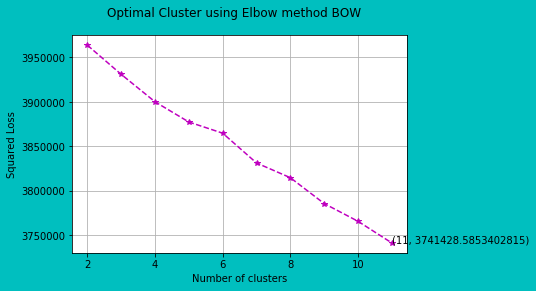

************************************************************


Avgword2vec


************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00, 13.22s/it]


The optimal number of clusters ==  11
The loss for optimal cluster is ==   201911.79165677723


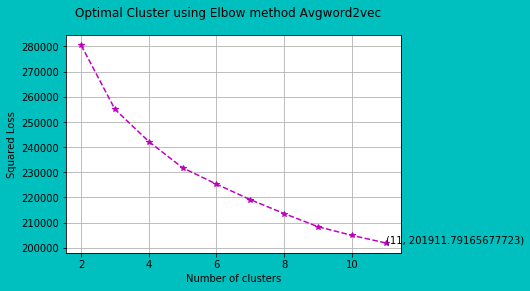

************************************************************


TFIDF


************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 13.85s/it]


The optimal number of clusters ==  11
The loss for optimal cluster is ==   3701256.2843268523


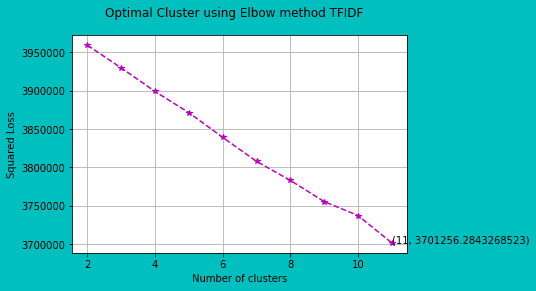

************************************************************


TFIDFweightedword2vec


************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 14.40s/it]


The optimal number of clusters ==  11
The loss for optimal cluster is ==   201911.9856714286


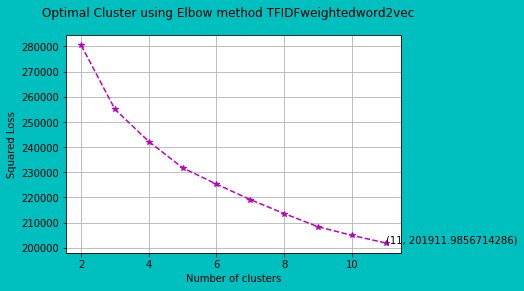

In [48]:

Optimal_cluster_vect=[]

for y in range(len(vect_name)):
            print("*" * 60)
            print("\n")
            print(vect_name[y])
            print("\n")
            print("*" * 60)
            Optimal_cluster_kmeans(vectorization_output[y],vect_name[y])
            Optimal_cluster_vect.append(Optimal_cluster)
               
            

In [49]:
Optimal_cluster_vect

[11, 11, 11, 11]

### Best model with Optimal cluster  Using Kmeans++  for Each vectorization techniques

In [50]:
# Training the best model
model_kmeans=[]
for i in tqdm(range(len(Optimal_cluster_vect))):
        print("$__$__" * 10)

        print('\n') 
        
        model = KMeans(n_clusters = Optimal_cluster_vect[i], n_jobs = -1)
        model.fit(vectorization_output[i])
        model_kmeans.append(model)
        print(str(vect_name[i])+'==',model)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__


BOW== KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


 25%|█████████████████████                                                               | 1/4 [00:10<00:30, 10.26s/it]

$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__


Avgword2vec== KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


 50%|██████████████████████████████████████████                                          | 2/4 [00:27<00:25, 12.50s/it]

$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__


TFIDF== KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:42<00:13, 13.15s/it]

$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__$__


TFIDFweightedword2vec== KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.33s/it]


'model_kmeans' is calualted with optimal k value for each vectorization. Optimal cluster size =11 for each vectorizied technique.

### Labels a cluster to Each  Review

 Giving Labels a cluster to each text Review. 

In [51]:
# Giving Labels a cluster to each text Review
model_col_nam=['BOW_Label','Avgword2vec','TFIDF','TFIDFword2vec']
df = X_Text
for k in tqdm(range(len(model_kmeans))):
   
        name=model_col_nam[k]
        df[name] = model_kmeans[k].labels_
df.head()  


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


,CleanedText,BOW_Label,Avgword2vec,TFIDF,TFIDFword2vec
150523,b'witti littl book make son laugh loud recit c...,9,2,2,6
150500,b'rememb see show air televis year ago child s...,1,2,2,6
451855,b'beetlejuic well written movi everyth excel a...,9,2,2,6
374358,b'twist rumplestiskin captur film star michael...,1,2,2,6
451854,b'beetlejuic excel funni movi keaton hilari wa...,1,2,2,6


####  How many points belong to each cluster 

In [52]:

df1=df.groupby(['BOW_Label'])['CleanedText'].count()
df2=df.groupby(['Avgword2vec'])['CleanedText'].count()
df3=df.groupby(['TFIDF'])['CleanedText'].count()
df4=df.groupby(['TFIDFword2vec'])['CleanedText'].count()
df5=pd.concat([df1, df2,df3,df4], axis=1).replace(np.nan, 0)
df5.columns=model_col_nam

#print(df5)


In [53]:
result_display(df5)

|BOW_Label|Avgword2vec|TFIDF|TFIDFword2vec|
|--------:|----------:|----:|------------:|
|      334|       2350| 1883|         3083|
|    22730|       2574| 2668|         3594|
|     5758|       7472|23548|         4497|
|      815|       3052| 1612|         2348|
|      212|       3086|  318|         3381|
|        7|       2993|  912|         2274|
|      510|       4726| 5285|         7477|
|     2691|       4496| 1017|         3001|
|     1463|       3393|  666|         2575|
|     5219|       3582| 1691|         3046|
|      261|       2276|  400|         4724|


## KMeans Cluster Bar Graph and Displaying Reviews text assigned to Random cluster for BOW vectorization

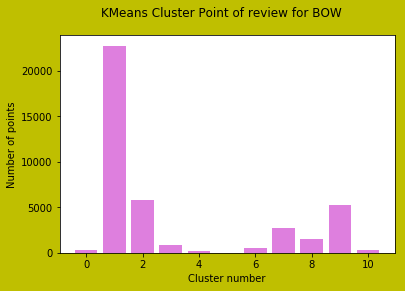

A review  cleaned text  assigned to cluster  4
************************************************************
b'yes juic appar person love drink lead orang carbon soft drink franc love drink flavor carbon juic like super sweet orang drink normal carbon like carbon water splash real orang juic flavor think first tast juic next moulin roug pari least rememb ate lunch step tour bus anyway imagin surpris found also sold local tea shop groceri store delici light tast over sweet perfect picnic parti rebecca review'


************************************************************


In [54]:
fig4 = plt.figure( facecolor='y', edgecolor='k')
fig4.suptitle('KMeans Cluster Point of review for BOW', fontsize=12)

plt.bar([x for x in range(Optimal_cluster_vect[0])], 
        df.groupby(['BOW_Label'])['CleanedText'].count(),
        color='m',alpha = 0.5)
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

random_cluster=random.randint(0, Optimal_cluster_vect[0])
#for i in range(Optimal_cluster_vect[0]):
print("A review  cleaned text  assigned to cluster ", random_cluster)
print("*" * 60)
text_data=df.loc[df.groupby(['BOW_Label']).groups[random_cluster][0]]['CleanedText']
print(text_data)
print('\n')
print("*" * 60)

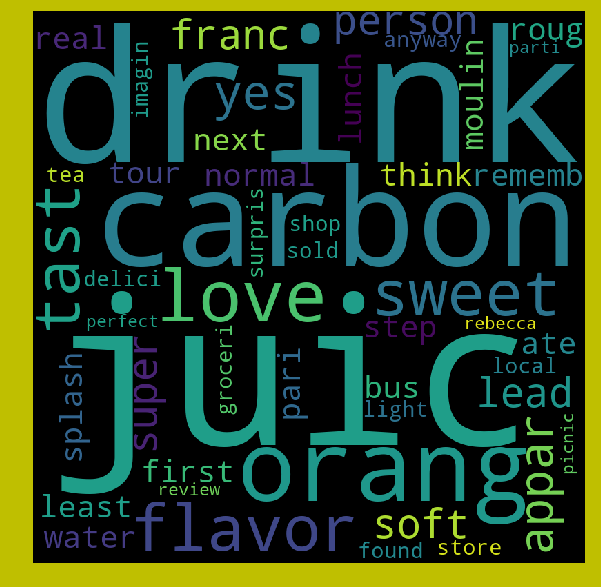

In [55]:
word_cloud_form(text_data)

* Random Cluster = 7 is about reviews which contained movie reviews which can be seen in wordcloud.
 

## KMeans Cluster Bar Graph and Displaying Reviews text assigned to Random cluster for Avgword2vec vectorization

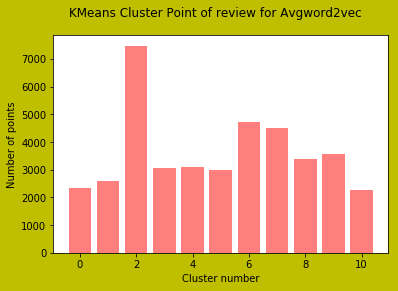

A review  cleaned text  assigned to cluster  1
************************************************************
b'tri various cat litter made thing clay cat less impact environ flush everyth toilet tri world best cat litter basic toast crack corn work quit well even automat litter box howev expens pound end spend close month litter two cat saw swheat scoop half price thought tri similar world best made wheat flushabl natur problem work horribl automat box although claim use cat liquid wast turn litter pasti sticki gob stick litter box bottom rake come clean box simpli isnt worth price save want natur cat litter least automat box guess would passabl convent litter box'


************************************************************


In [56]:
fig6 = plt.figure( facecolor='y', edgecolor='k')
fig6.suptitle('KMeans Cluster Point of review for Avgword2vec', fontsize=12)
plt.bar([x for x in range(Optimal_cluster_vect[1])], df.groupby(['Avgword2vec'])['CleanedText'].count(),color='r',alpha = 0.5)
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

#for i in range(Optimal_cluster):
random_cluster=random.randint(0, Optimal_cluster_vect[1])
print("A review  cleaned text  assigned to cluster ", random_cluster)
print("*" * 60)
text_data1=df.loc[df.groupby(['Avgword2vec']).groups[random_cluster][0]]['CleanedText']
print(text_data1)
print('\n')
print("*" * 60)

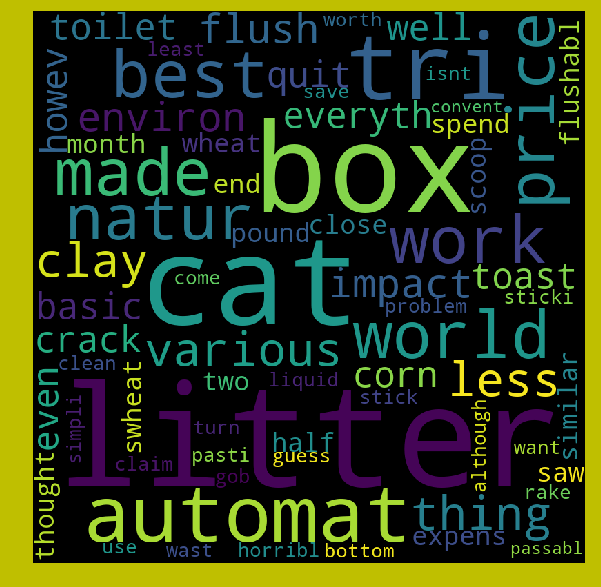

In [57]:
word_cloud_form(text_data1)

* Bar graph represents the cluster which shows counts of labelled reviews.

* Random Cluster = 10 is about reviews which contained color product (color  realted reviews)  reviews which can be seen in wordcloud.

 

## KMeans Cluster Bar Graph and Displaying Reviews text assigned to   Random cluster for TFIDF vectorization

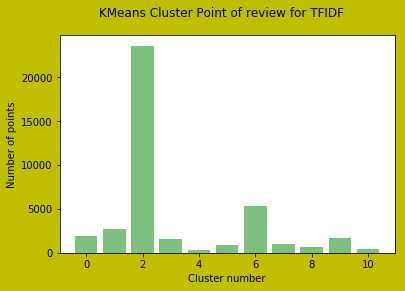

A review  cleaned text  assigned to cluster  6
************************************************************
b'product remind thousand lunch chicken teriyaki mound steam rice eat drizzl soy food home make everyday teriyaki day'


************************************************************


In [58]:
fig7 = plt.figure( facecolor='y', edgecolor='k')
fig7.suptitle('KMeans Cluster Point of review for TFIDF', fontsize=12)
plt.bar([x for x in range(Optimal_cluster_vect[2])], df.groupby(['TFIDF'])['CleanedText'].count(),color='g',alpha = 0.5)
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

#for i in range(Optimal_cluster):
random_cluster=random.randint(0, Optimal_cluster_vect[2])
print("A review  cleaned text  assigned to cluster ", random_cluster)
print("*" * 60)
text_data2=df.loc[df.groupby(['TFIDF']).groups[random_cluster][0]]['CleanedText']
print(text_data2)
print('\n')
print("*" * 60)

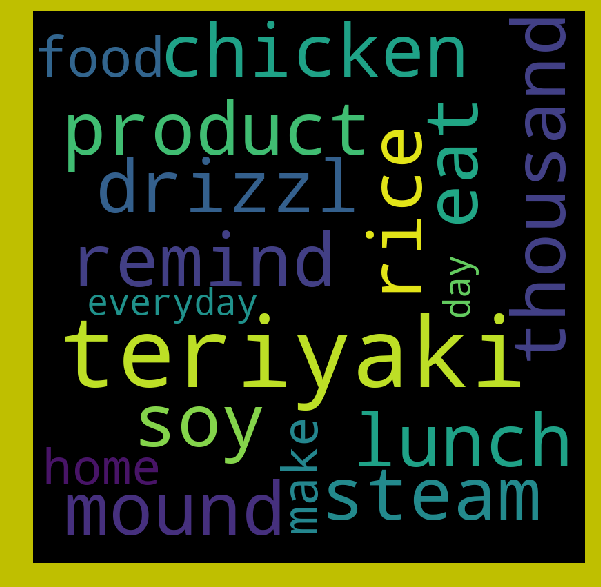

In [59]:
word_cloud_form(text_data2)

* Bar graph represents the cluster which shows counts of labelled reviews.

* Random Cluster = 7 is about reviews which contained food product (food taste realted things)  reviews which can be seen in wordcloud.

 

## KMeans Cluster Bar Graph and Displaying Reviews text assigned to each cluster for TFIDF weighted word2vec vectorization

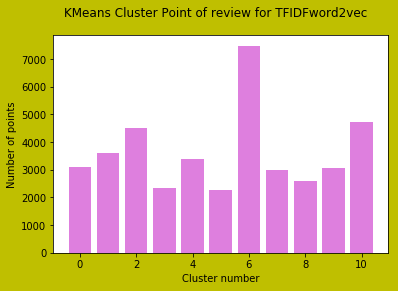

A review  cleaned text  assigned to cluster  3
************************************************************
b'year tri simul truli italian espresso cappuccino without success sever packag arriv christma son sent briel cadiz espresso machin two love russian china cup case espression classic espresso pod kindest wonder christma present rememb espresso machin excel qualiti eas use espresso exquisit time prepar espresso cappuccino experi son love kind small part mani gift itali heaven earth'


************************************************************


In [60]:
fig7 = plt.figure( facecolor='y', edgecolor='k')
fig7.suptitle('KMeans Cluster Point of review for TFIDFword2vec', fontsize=12)
plt.bar([x for x in range(Optimal_cluster_vect[3])], df.groupby(['TFIDFword2vec'])['CleanedText'].count(),color='m',alpha = 0.5)
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

#for i in range(Optimal_cluster):
random_cluster=random.randint(0, Optimal_cluster_vect[2])
print("A review  cleaned text  assigned to cluster ", i)
print("*" * 60)
text_data3=df.loc[df.groupby(['TFIDFword2vec']).groups[i][0]]['CleanedText']
print(text_data3)
print('\n')
print("*" * 60)

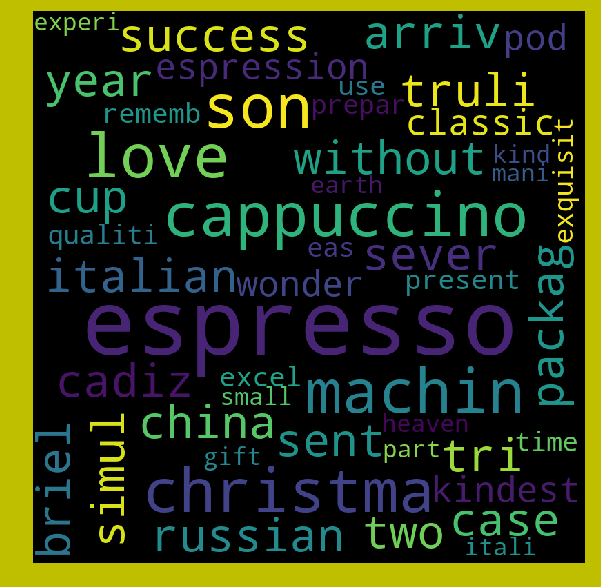

In [61]:
word_cloud_form(text_data3)

* Bar graph represents the cluster which shows counts of labelled reviews.

* Random Cluster = 3 is about reviews which is realted to supermarket praising .

### Observations for kmeans++


|BOW_Label|Avgword2vec|TFIDF|TFIDFword2vec|
|--------:|----------:|----:|------------:|
|    22164|       2842| 1790|         3111|
|     3907|       4028| 1767|         4428|
|     3405|       5303|  900|         2545|
|     3072|       2329|  871|         4740|
|      245|       5213| 4426|         3544|
|     2275|       3048|  200|         7461|
|      596|       4942| 2740|         2355|
|     3216|       2446|  597|         3036|
|      708|       2934|  677|         3368|
|        1|       3968|25391|         3053|
|      411|       2947|  641|         2359|

* Reviews which are preprocessed(cleaned Text) is clustered .And reviews in each set with given cluster number is viewd as above for each vectorization .

* Avg word2vec & tfIDF weighted word2vec are distributed review's word with equal probably manners.Each cluster contains equally distributed words for given cluster number.

* In case of BOW & TFIDF,Words distribution is unequal .For some clusters, words allocation is high while for other extremely low.

* Reviews are clustered with kmeans++ algorithm.



# 2.Hierarchical Clustering

In [74]:
# Checking agglomerative Clustering groupings ->
cluster_name=['cluster_BOW','cluster_Avgword2vec','cluster_tfidf','cluster_tfidfword2vec']
#cluster_optimal=
def agglomerative_Cluster(vectorization_output,cluster_name):    

    df = X_Text
    random_cluster=random.randint(0, (len(cluster_range)-3))
    #random_cluster=2
    #for cluster in tqdm(range(len(cluster_range))):
        
    agg = AgglomerativeClustering(n_clusters=cluster_range[random_cluster])
    agg.fit(vectorization_output)

    print("*" * 40, "  For Number of Clusters = ",random_cluster, "  ", "*" * 40)
    print("\nReviews for each of the clusters : \n")
    df = X_Text[:5000]
    df[cluster_name] = agg.labels_

    df = df.groupby([cluster_name])


    # Printing two reviews from each cluster, if they contain at-least points.
    for i in range(random_cluster):
        print("For cluster ", i, "\n")

        print("Review 1 -> \n")
        review_1=X_Text.loc[df.groups[i][0]]['CleanedText']
        print(review_1)
        word_cloud_form(review_1)



        if(len(df.groups[i]) > 1):

            print("\n")
            print("Review 2 ->  ,\n")
            review_2=X_Text.loc[df.groups[i][1]]['CleanedText']
            print(review_2)
            word_cloud_form(review_2)
        print("-" * 80)

    print("_" * 80)
    print("\n")

****************************************   For Number of Clusters =  1    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'


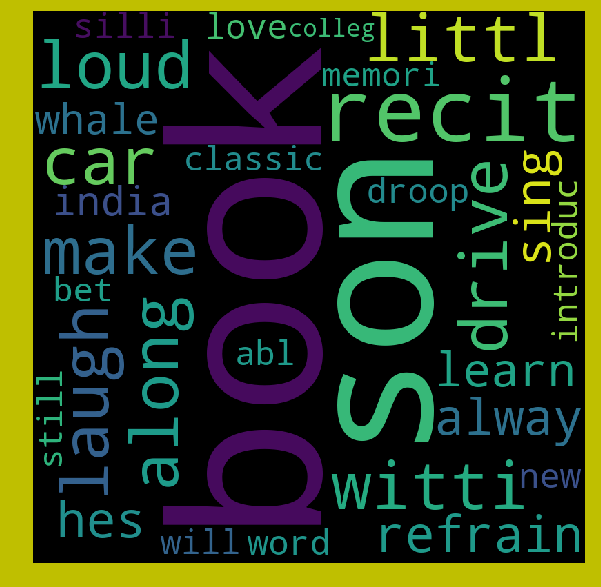



Review 2 ->  ,

b'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live'


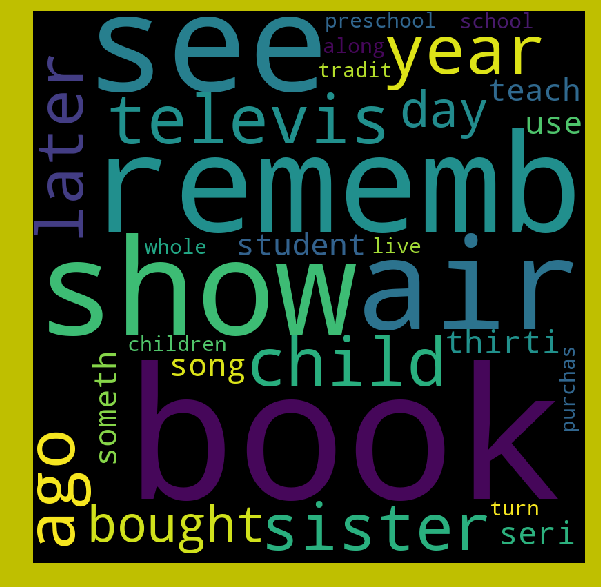

--------------------------------------------------------------------------------
________________________________________________________________________________




In [75]:
agglomerative_Cluster(vectorization_output[0],cluster_name[0])

****************************************   For Number of Clusters =  7    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

b'food color kit sound great except give ounc size bottl what would nice know much product get dollar'


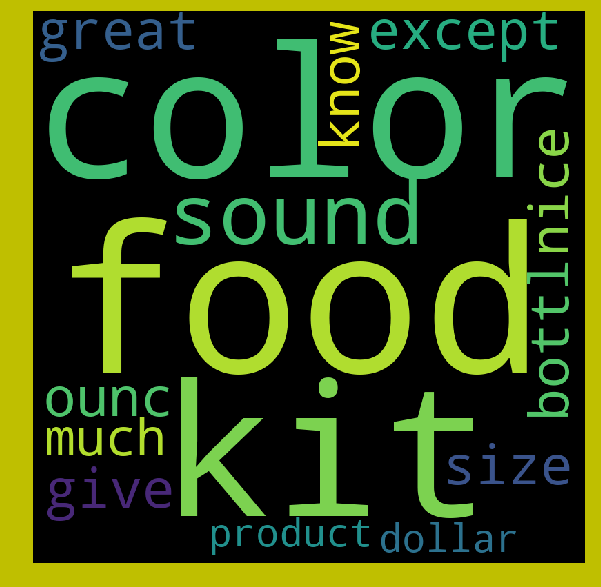



Review 2 ->  ,

b'return due short brief expir date sept would less use pod amazon pull shelv'


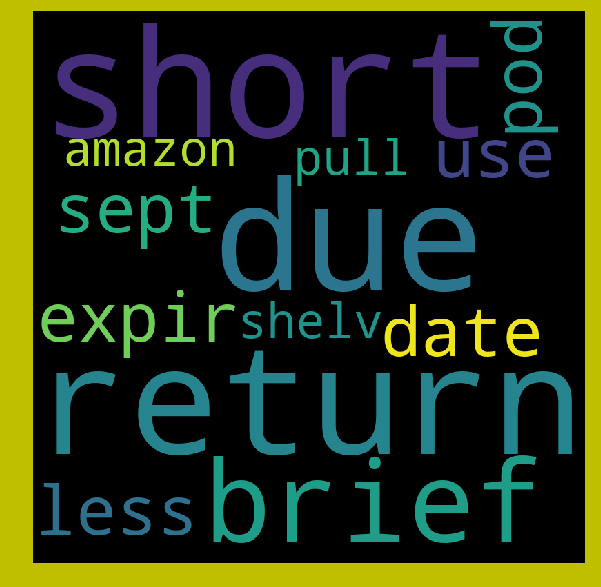

--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

b'get crazi realli imposs today find french vhs version film pleas tell someth tks'


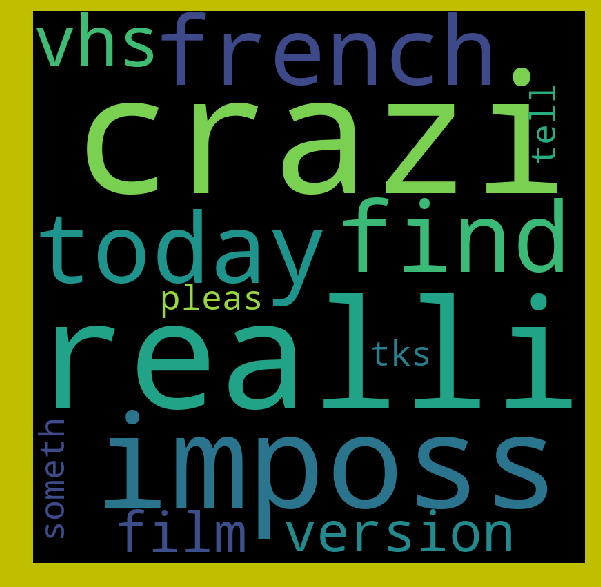



Review 2 ->  ,

b'get crazi look beatlejuic french version video realli imposs today find french vhs version film pleas tell someth tks'


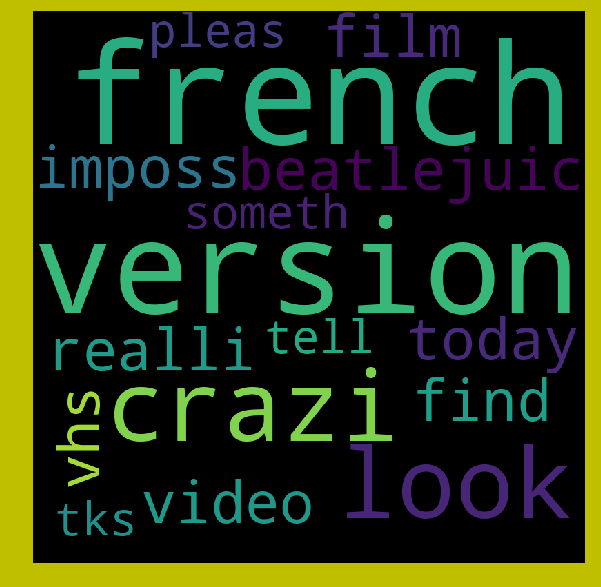

--------------------------------------------------------------------------------
For cluster  2 

Review 1 -> 

b'day get colder noth reward simpl cup hot tea claim immun benefit basic green tea common pick maintain healthi natur balanc flu season previous experi tast tazo brand bottl box product proven unsurpass qualiti flavor ive tri tea immedi becam drink choic zen green tea blend wonder one ingredi artifici anyth thank doesnt boast addit fortifi vitamin senseless amount truli enlighten blend green tea spearmint lemongrass lemon verbena thus make versatil refresh anytim day whether right meal meal bedtim general light mild tast depend upon long steep add sweeten form amus comment remark appear packag read drink tea make distinct experi never seen tea clever wonder consum tazo realli improv person outlook life affect well think could great tast aroma probabl reassur thought health favor coupl tea sure tazo zen green tea make good choic'


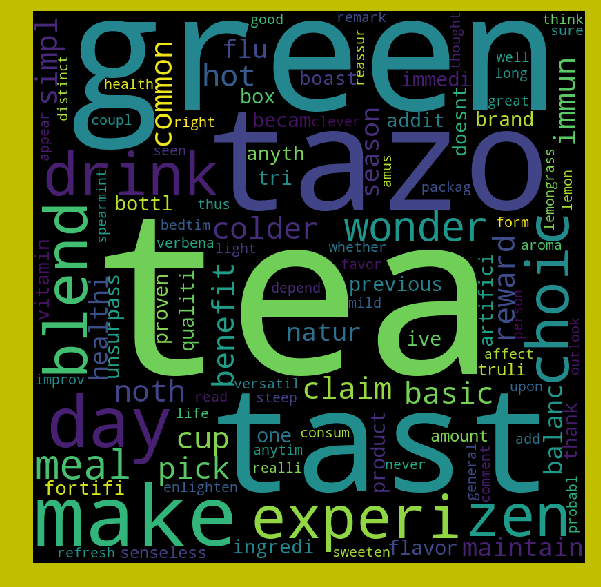



Review 2 ->  ,

b'like earl grey tea youll find better harney son blend youv tri earl grey suprem wont abl live without other seem wash comparison'


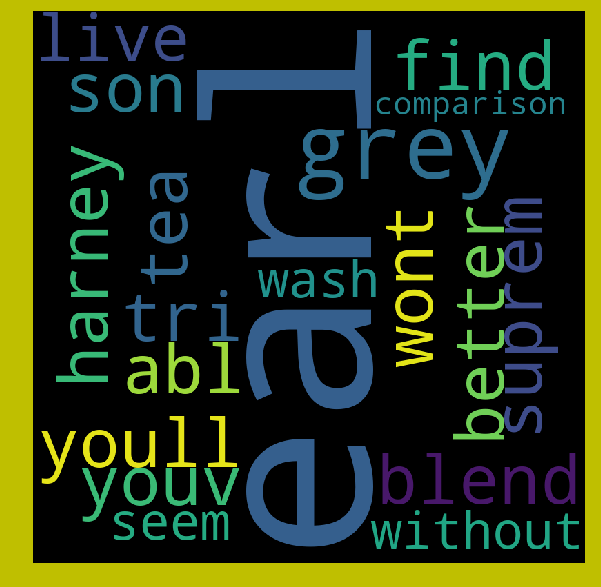

--------------------------------------------------------------------------------
For cluster  3 

Review 1 -> 

b'sick scad nasti toothpick counter tint concept one long overdu except welcom color vibrant offens tast blend opinion smooth wilton past youll need experi bit get hue right first well worth'


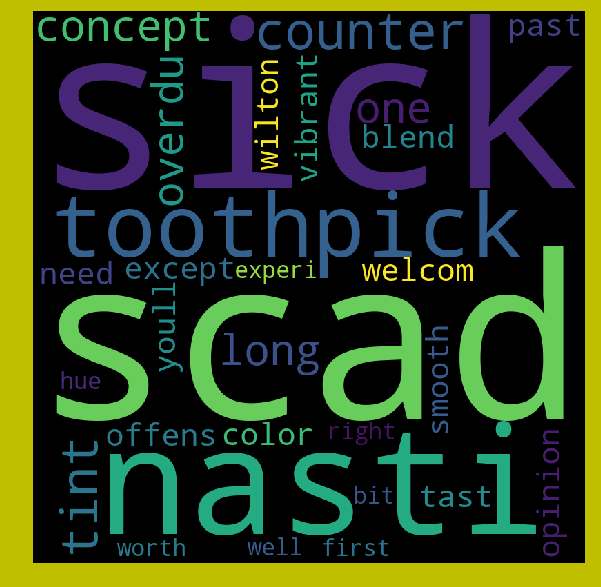



Review 2 ->  ,

b'thought movi funni michael keaton beetlejuic right alec baldwin play geeki husband priceless love scenc kid realli enjoy one'


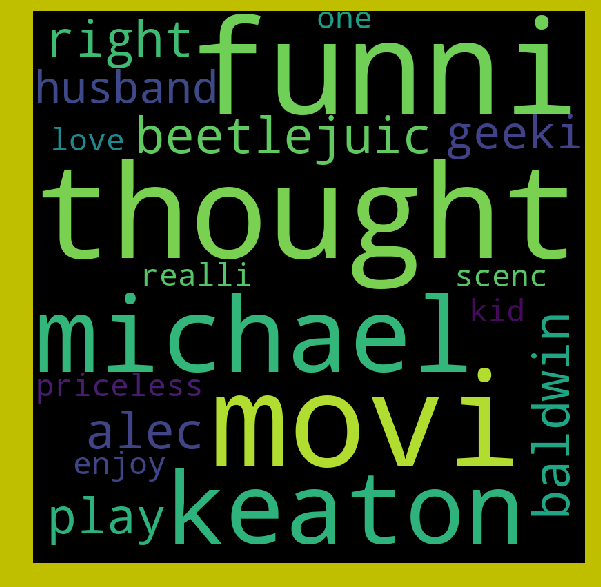

--------------------------------------------------------------------------------
For cluster  4 

Review 1 -> 

b'year tri simul truli italian espresso cappuccino without success sever packag arriv christma son sent briel cadiz espresso machin two love russian china cup case espression classic espresso pod kindest wonder christma present rememb espresso machin excel qualiti eas use espresso exquisit time prepar espresso cappuccino experi son love kind small part mani gift itali heaven earth'


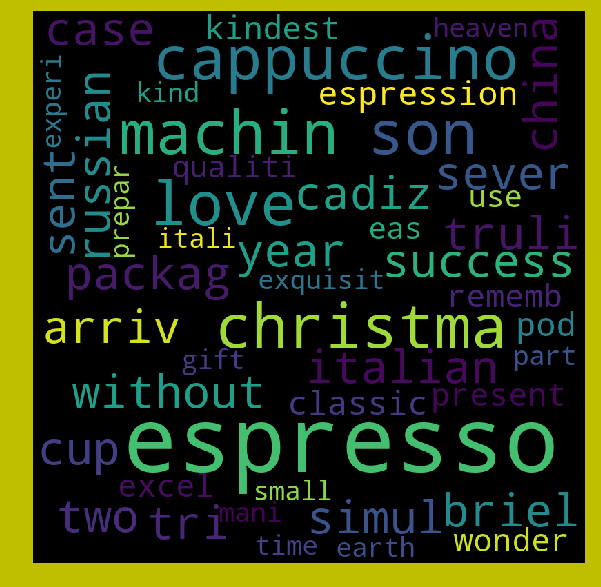



Review 2 ->  ,

b'use briel chamonix machin purchas amazon produc delici latt use pod smell espression pod regular decaf open incred dark rich roast fyi pod produc itali good sign also pod handi paper tab remov machin without burn finger compar pod starbuck espresso pod regular decaf espression favorit one pod individu wrap take lot space sure know your go store good box stamp best use date case month date purchas'


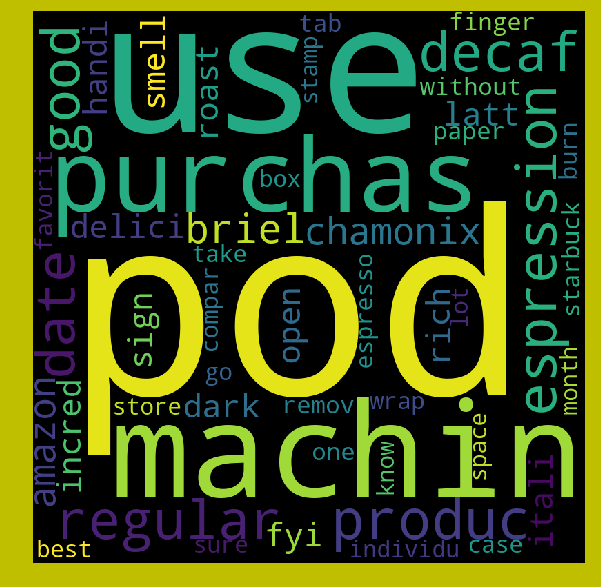

--------------------------------------------------------------------------------
For cluster  5 

Review 1 -> 

b'cat like sauci food fanci feast grill rang good bet cat pretti fussi hell eat grill varieti favourit far grill salmon judg fact never stock pet food store favourit mani pussi tuna next favourit like grill chicken chang lot sauc conveni small can cat dont eat lot one sit pretti decent ingredi smell three whisker'


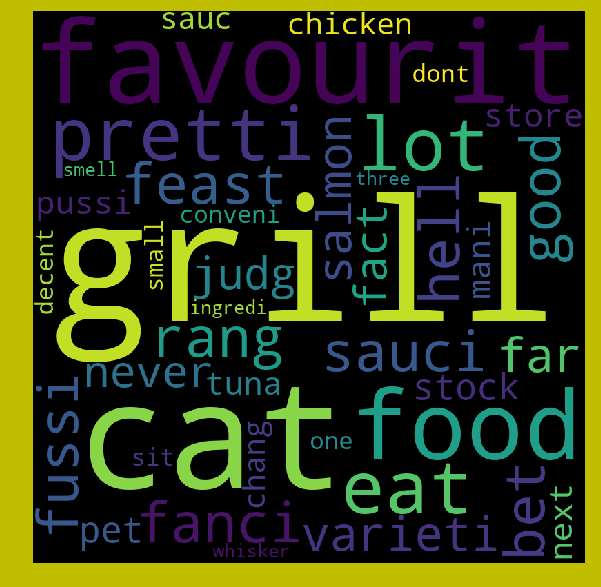



Review 2 ->  ,

b'love meow mix cat love eat togther cat kittl use attack brother franci could get delious belend chicken liver buy pleas'


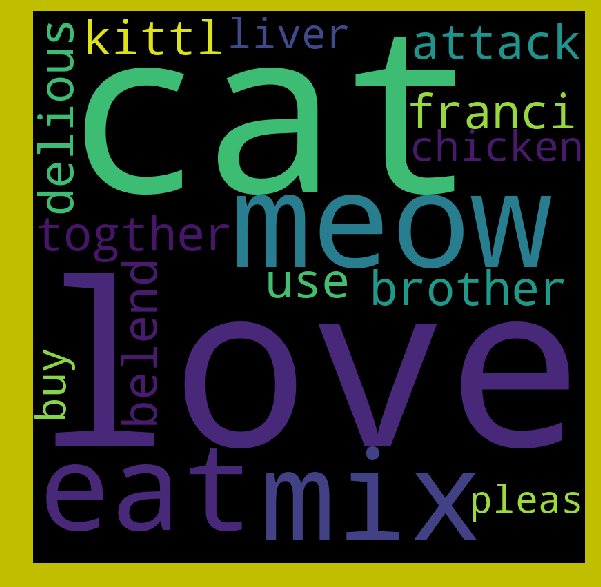

--------------------------------------------------------------------------------
For cluster  6 

Review 1 -> 

b'definit guilti pleasur often think suppos like film cant help cast make solid rewatch vehicl also steadi feel burton film great product valu great sens abil frighten delight time'


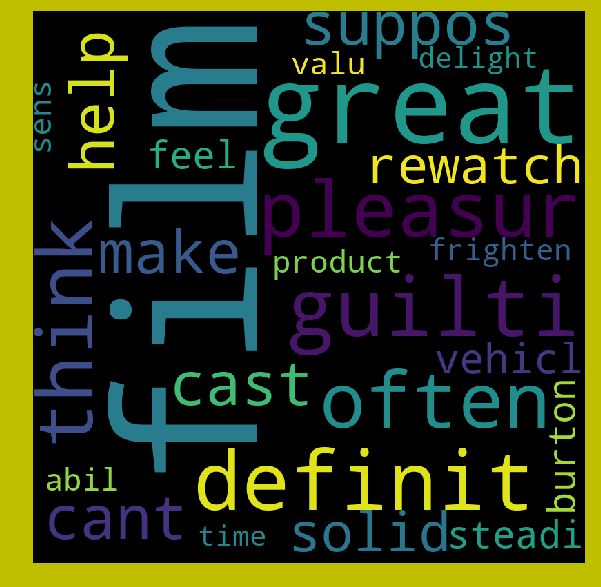



Review 2 ->  ,

b'bake organ vanilla past realiz vanilla extract found product mislead even though categor organ product'


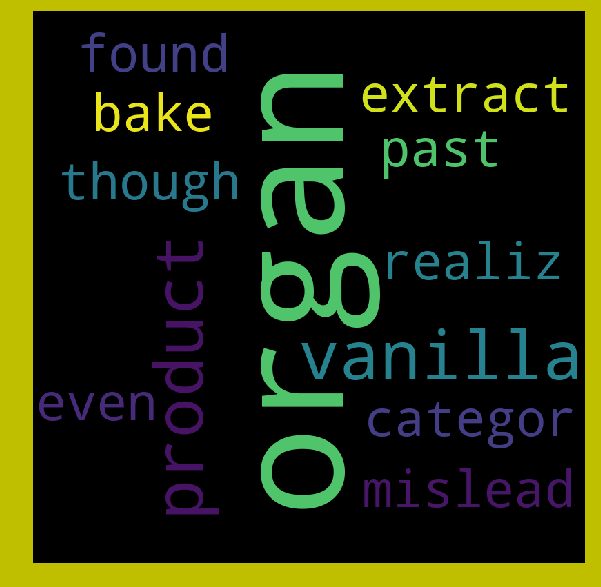

--------------------------------------------------------------------------------
________________________________________________________________________________




In [76]:
agglomerative_Cluster(vectorization_output[1],cluster_name[1])

****************************************   For Number of Clusters =  1    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'


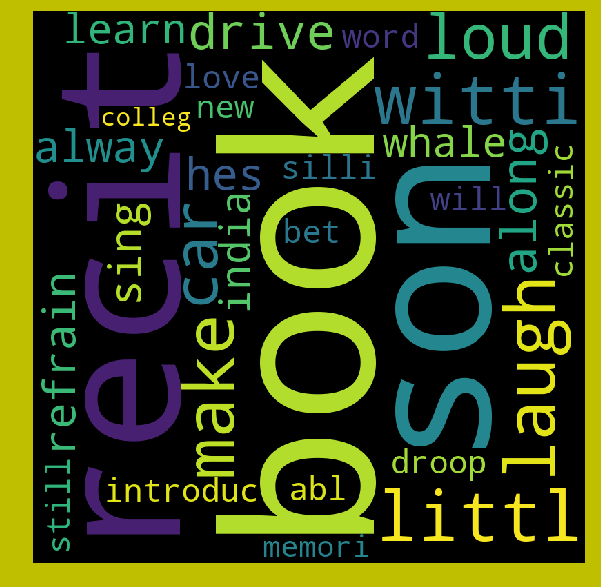



Review 2 ->  ,

b'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live'


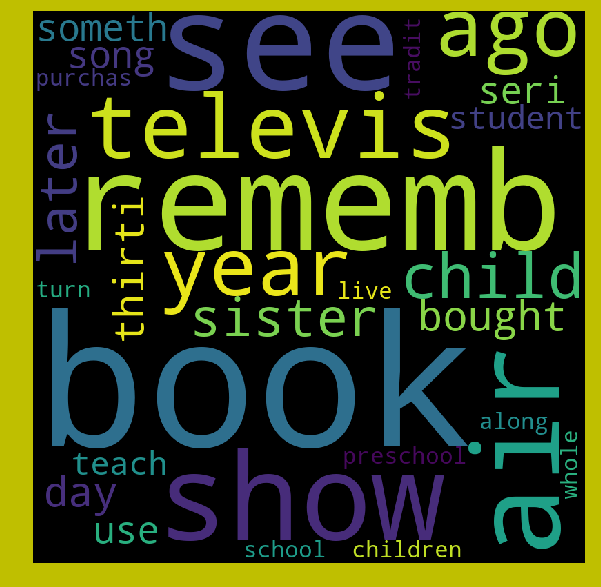

--------------------------------------------------------------------------------
________________________________________________________________________________




In [77]:
 # This code cell is for agglomerative  using Tf-IDf
agglomerative_Cluster(vectorization_output[2],cluster_name[2])

****************************************   For Number of Clusters =  2    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

b'year tri simul truli italian espresso cappuccino without success sever packag arriv christma son sent briel cadiz espresso machin two love russian china cup case espression classic espresso pod kindest wonder christma present rememb espresso machin excel qualiti eas use espresso exquisit time prepar espresso cappuccino experi son love kind small part mani gift itali heaven earth'


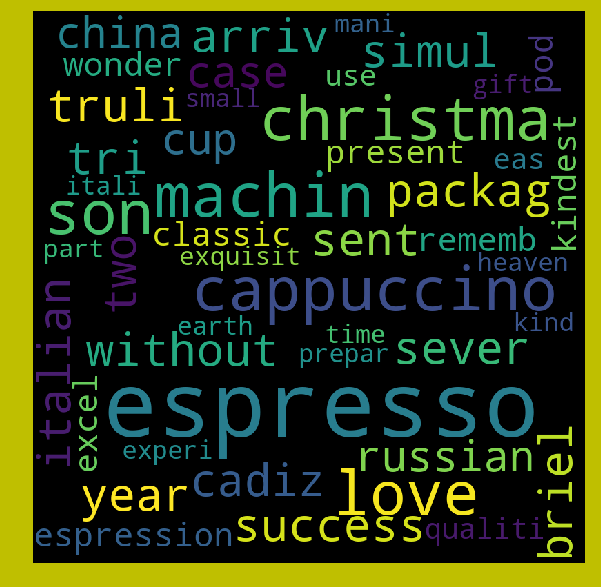



Review 2 ->  ,

b'use briel chamonix machin purchas amazon produc delici latt use pod smell espression pod regular decaf open incred dark rich roast fyi pod produc itali good sign also pod handi paper tab remov machin without burn finger compar pod starbuck espresso pod regular decaf espression favorit one pod individu wrap take lot space sure know your go store good box stamp best use date case month date purchas'


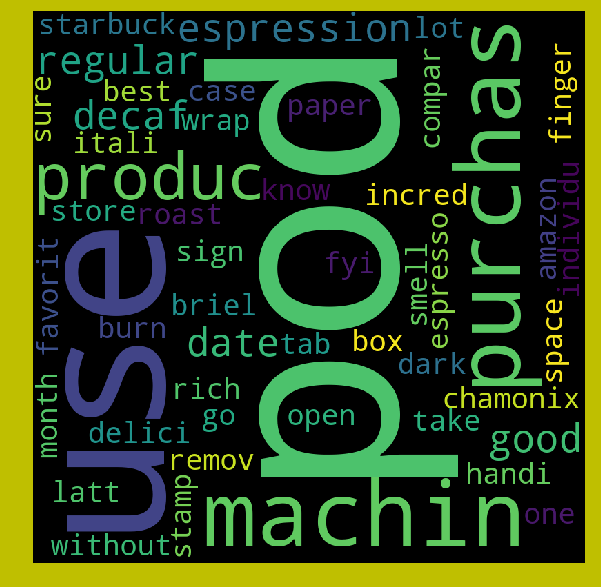

--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'


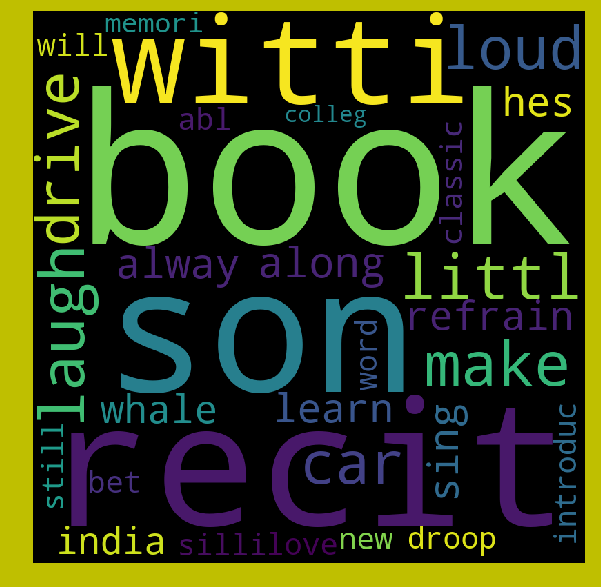



Review 2 ->  ,

b'rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live'


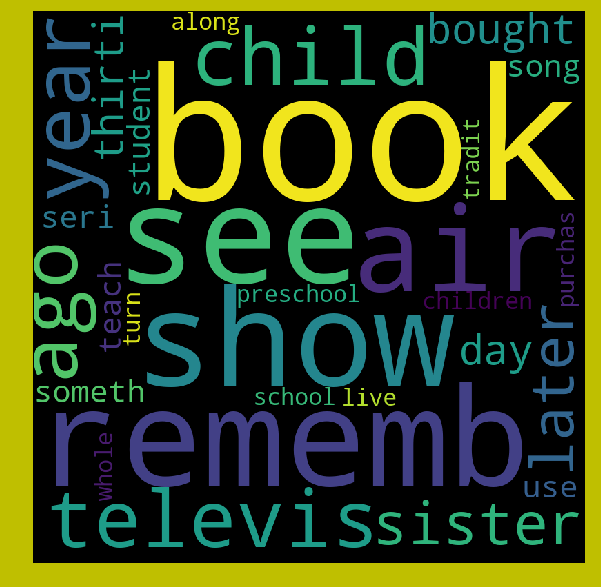

--------------------------------------------------------------------------------
________________________________________________________________________________




In [78]:
# This code cell is for agglomerative  usinf tf-idf weighted word2vec
agglomerative_Cluster(vectorization_output[3],cluster_name[3])


## Observation for Hierarchical clustering using agglomerative method

* In Agglomerative Clustering, Random Cluster number is selected and then How agglomerative cluster is clustered from cluster 0 to random cluster number is shown. 
* Wordcloud visualized each cluster review as seen in above. 

* here,Hierarchical clustering is using the types named as agglomerative hierarchical clustering.
* As in agglomerative methods,group of cluster is clustered based on similarity or distance between clusters.
* As above with each featurization techniques, 5k reviews are clustered with agglomerative method.
* we can see the similarity between  review1 and review2 for particular sets(contains reviews) in given cluster.


# DBSCAN(Density Based spital clustering of application with noise)

In [79]:
# Computing 200th Nearest neighbour distance code.
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200_nearest_neighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

## Computing the 200th Nearest Neighbour Distance of points in the dataset

In [80]:
# Computing the 200th nearest neighbour distance of some point the dataset:
neigh200 = []
for val in vectorization_output[1]:
    neigh200.append( compute200_nearest_neighbour(val, vectorization_output[1]) )
neigh200.sort()

### Plotting for the Elbow Method

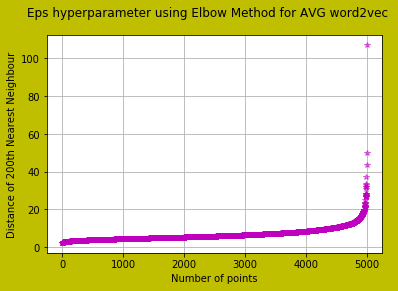

In [81]:

fig4 = plt.figure( facecolor='y', edgecolor='k')
fig4.suptitle('Eps hyperparameter using Elbow Method for AVG word2vec ', fontsize=12)    
plt.plot([x for x in range(len(neigh200 ))], neigh200 ,'m*', alpha = 0.5)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.grid()
plt.show()

The Knee point seems to be 18. So Eps = 18

In [82]:
# Training DBSCAN :
model = DBSCAN(eps = 18, min_samples = minPts, n_jobs=-1)
model.fit(vectorization_output[1])


DBSCAN(algorithm='auto', eps=18, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [83]:
df1 =X1[:5000]

#word_cloud_form(df1['CleanedText'][0])
df1['AVG-W2V_Label'] = model.labels_
df1.head(2)

,CleanedText,AVG-W2V_Label
150523,b'witti littl book make son laugh loud recit c...,0
150500,b'rememb see show air televis year ago child s...,0


In [84]:
df1.groupby(['AVG-W2V_Label'])['CleanedText'].count()

AVG-W2V_Label
0    5000
Name: CleanedText, dtype: int64

All Cluster labels for each point in the dataset given to fit()(model).No noise point is lied within cluster at eps=18 and min_samples=200.

### For different values of eps

#### Let's check the clustering with different values of eps  with minpts=200

In [85]:
diff_eps=[0.6,0.8,1,6,8,12,15,18,20]

In [86]:

for eps_val in range(len(diff_eps)):
    
    model = DBSCAN(eps =diff_eps[eps_val], min_samples = minPts, n_jobs=-1)
    model.fit(vectorization_output[1])
    print ("\n")
    print ("*" * 70)
    print("for eps value ===",diff_eps[eps_val])
    df1 =X1[:5000]
    df1['AVG-W2V_Label'] = model.labels_
    df2=df1.groupby(['AVG-W2V_Label'])['CleanedText'].count()
   
    print(df2)



**********************************************************************
for eps value === 0.6
AVG-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 0.8
AVG-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 1
AVG-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 6
AVG-W2V_Label
-1       1
 0    4999
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 8
AVG-W2V_Label
-1       1
 0    4999
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 12
AVG-W2V_Label
0    5000
Name: CleanedText, dtype: int64


**********************************************************************
f

#### Noisy samples are given the label -1 in a cluster.

* eps value lies in this range  [0.6,0.8,1] is showing all samples points are noise point.
* For eps value [6,8], one point is noise point and rest of point is cluster point

* eps value lies between [12,15,18,20] is labelling all points as cluster point

## Computing the 200th Nearest Neighbour Distance of points in the dataset

In [87]:
# Computing the 200th nearest neighbour distance of some point the dataset:
neigh200_tf = []
for val in vectorization_output[3]:
    neigh200_tf.append( compute200_nearest_neighbour(val, vectorization_output[3]) )
neigh200_tf.sort()

### Plotting for the Elbow Method

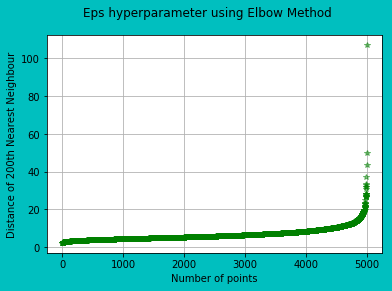

In [88]:

fig4 = plt.figure( facecolor='c', edgecolor='k')
fig4.suptitle('Eps hyperparameter using Elbow Method ', fontsize=12)    
plt.plot([x for x in range(len(neigh200_tf ))], neigh200_tf ,'g*', alpha = 0.5)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.grid()
plt.show()

In [89]:
# Training DBSCAN :
model = DBSCAN(eps = 20, min_samples = minPts, n_jobs=-1)
model.fit(vectorization_output[3])

DBSCAN(algorithm='auto', eps=20, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [90]:

df1['TFIDF-W2V_Label'] = model.labels_
df1.head(2)

,CleanedText,AVG-W2V_Label,TFIDF-W2V_Label
150523,b'witti littl book make son laugh loud recit c...,0,0
150500,b'rememb see show air televis year ago child s...,0,0


All Cluster labels for each point in the dataset given to fit()(model).No noise point is lied within cluster at eps=20 and min_samples=200.

In [91]:
df1.groupby(['TFIDF-W2V_Label'])['CleanedText'].count()

TFIDF-W2V_Label
0    5000
Name: CleanedText, dtype: int64

In [92]:
for eps_val in range(len(diff_eps)):
    
    model = DBSCAN(eps =diff_eps[eps_val], min_samples = minPts, n_jobs=-1)
    model.fit(vectorization_output[3])
    print ("\n")
    print ("*" * 70)
    print("for eps value ===",diff_eps[eps_val])
    df1 =X1[:5000]
    df1['TFIDF-W2V_Label'] = model.labels_
    #df2=df.groupby(['AVG-W2V_Label'])['CleanedText'].count()
    df2=df1.groupby(['TFIDF-W2V_Label'])['CleanedText'].count()
   
    print(df2)



**********************************************************************
for eps value === 0.6
TFIDF-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 0.8
TFIDF-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 1
TFIDF-W2V_Label
-1    5000
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 6
TFIDF-W2V_Label
-1       1
 0    4999
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 8
TFIDF-W2V_Label
-1       1
 0    4999
Name: CleanedText, dtype: int64


**********************************************************************
for eps value === 12
TFIDF-W2V_Label
0    5000
Name: CleanedText, dtype: int64


************************************************************

#### Noisy samples are given the label -1 in a cluster.

* eps value lies in this range  [0.6,0.81] is showing all samples points are noise point.
* eps value=[6,8] are labelling 1 ponit as noise points and rest of the point as a cluster points.

* eps value lies between [12,15,18,20] is labelling all points as cluster point

#### It can be observed that DBSCAN is sensitive to eps

#### Observations:


* Clustering techniques labelling varies based on size, density and globular shape.
* With Kmeans++, kmedoids,Hierarchical clustering(agglomerative clustering) and DBSCAN clustering  on amazon reviews clustered the reviews as seen above.
